# Современные библиотеки градиентного бустинга

В этом блокноте мы рассмотрим некоторые современные модели, как развитие идей наивной версии [градиентного бустинга](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) из scikit-learn, [придуманную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в 1999 году Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:
* **XGBoost**. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Одними из основных особенностей имплементации были оптимизированность построения деревьев, а также различные регуляризации модели.
* **LightGBM**. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O(\text{#bins})$. Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала. Таким образом, каждое дерево является цепочкой с прикрепленными листьями.
* **CatBoost**. Библиотека от компании Яндекс. Позволяет автоматически обрабатывать категориальные признаки (даже если их значения представлены в виде строк). Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров. За счёт этого уменьшается время, которое тратит человек на подбор оптимальных гиперпараметров.

## Описание основных параметров

(lightgbm/catboost)

* `objective` – функционал, на который будет настраиваться композиция
* `eta` / `learning_rate` – темп (скорость) обучения
* `num_iterations` / `n_estimators`  – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
* `max_depth` – максимальная глубина
* `max_leaves` / num_leaves – максимальное число вершин в дереве
* `gamma` / `min_gain_to_split` – порог на уменьшение функции ошибки при расщеплении в дереве
* `min_data_in_leaf` – минимальное число объектов в листе
* `min_sum_hessian_in_leaf` – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление
* `lambda` – коэффициент регуляризации (L2)
* `subsample` / `bagging_fraction` – какую часть объектов обучения использовать для построения одного дерева
* `colsample_bytree` / `feature_fraction` – какую часть признаков использовать для построения одного дерева

Подбор всех этих параметров — настоящее искусство. Но начать их настройку можно с самых главных параметров: `learning_rate` и `n_estimators`. Обычно один из них фиксируют, а оставшийся из этих двух параметров подбирают (например, фиксируют `n_estimators=1000` и подбирают `learning_rate`). Следующим по важности является `max_depth`. В силу того, что мы заинтересованы в неглубоких деревьях, обычно его перебирают из диапазона [3; 7].

# Практические эксперименты

# Подготовка данных

Установим и импортируем необходимые библиотеки

In [ ]:
!pip install -q catboost
!pip install -q lightgbm
!pip install -q xgboost
!pip install -q mlxtend
!pip install -q dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

Сгенерируем наборы данных. Рассмотрим данные разной структуры для того, чтобы более наглядно сравнить рассматриваемые модели.

In [ ]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

# Datasets
linearly_separable = (X, y)
moons = make_moons(noise=0.3, random_state=0)
circles = make_circles(noise=0.2, factor=0.5, random_state=1)

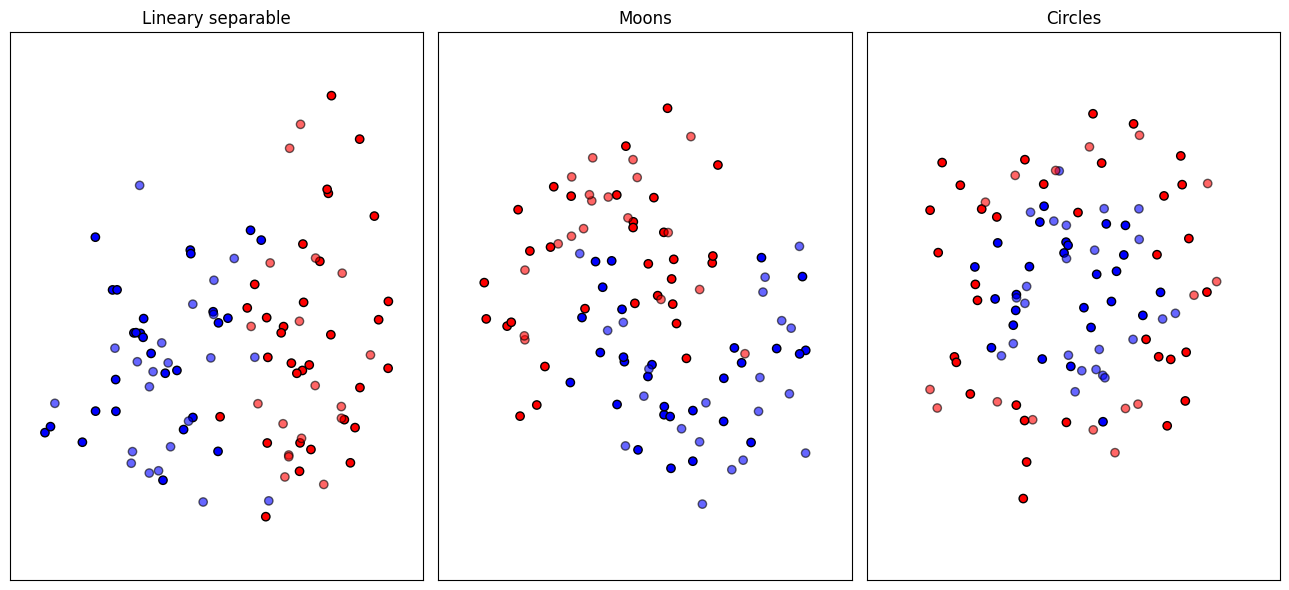

In [ ]:
# Plotting
figure = plt.figure(figsize=(13, 6))
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
titles = ['Lineary separable', 'Moons', 'Circles']

for i, ds in enumerate([linearly_separable, moons, circles]):
    plt.subplot(1, 3, i + 1)
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.tight_layout()
plt.show()

# Внутренняя структура данных

Рассмотрим, как анализируемые модели "справляются" с данным различной "формы". Для рассмотренных выше наборов данных: `linearly_separable, moons, circles`:
1. Разбейте на трейн/тест со следующими параметрами `test_size=0.4, random_state=42`.
2. Обучите на трейне, оцените (`Accuracy`) на тесте модели `XGBClassifier, LGBMClassifier,
    CatBoostClassifier`
3. Нарисуйте `DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.8, eps=0.5)`
4. При помощи `scatterplot` нарисуйте тренировочные и тестовые данные. Тестовые с `alpha=0.6`.
5. Интерпретируйте полученные результаты

### XGBClassifier

Accuracy:  0.725


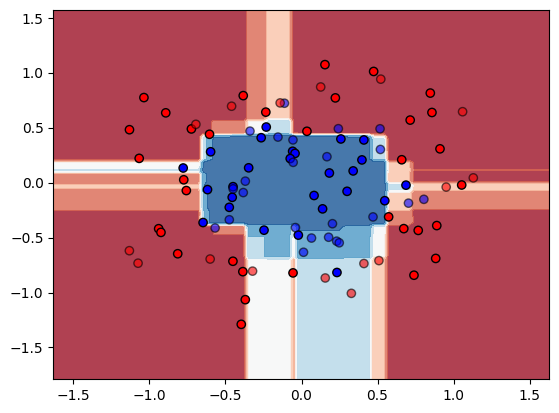

In [ ]:
# YOUR CODE HERE

#P.S. Для каждого набора данных и каждого классификатора должно получиться что то типа

### LGBMClassifier

In [ ]:
# YOUR CODE HERE

### CatBoostClassifier

In [ ]:
# YOUR CODE HERE

# Learning rate

Все рассматриваемые модели основаны на идее градиентного бустинга, проанализируем, как такой параметр, как `learning_rate` влияет на скорость и качество обучения моделей.

Будем использовать другой датасет

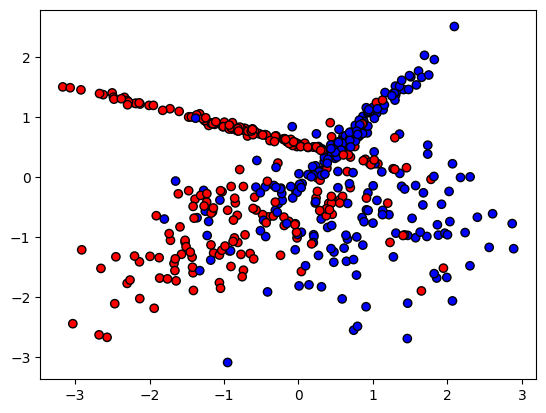

In [ ]:
from tqdm.notebook import tqdm

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k")

Далее все аналогично:
1. Сплит на трейн/тест
2. Обучение моделей с рассматриваемыми параметрами
3. Построение графиков (в данном случае зависимость `f_score` от `learning_rate`) для трейна и теста на одном холсте

### XGBClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=241)

lrs = np.arange(0.01, 1, 0.02)
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for l in tqdm(lrs):
    # YOUR CODE HERE

# YOUR CODE HERE (make the plot)

### LGBMClassifier

Использовать с дополнительным параметром `verbose=-1`

In [ ]:
lrs = np.arange(0.01, 1, 0.02)
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for l in tqdm(lrs):
    # YOUR CODE HERE

# YOUR CODE HERE (make the plot)

### CatBoostClassifier

Использовать с дополнительными параметрами `iterations=300, logging_level='Silent'`

In [ ]:
lrs = np.arange(0.01, 1, 0.02)
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for l in tqdm(lrs):
    # YOUR CODE HERE

# YOUR CODE HERE (make the plot)

# Number of trees

Исследуем влияние параметра `n_estimators` на результаты классификации в рассматриваемых моделях. Используйте набор данных из предыдущего пункта. Далее все аналогично:

1. Обучение моделей с рассматриваемыми параметрами
2. Построение графиков (в данном случае зависимость `f_score` от `n_estimators`) для трейна и теста на одном холсте

### XGBClassifier

In [ ]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for n in tqdm(n_trees):
    # YOUR CODE HERE

# YOUR CODE HERE (make the plot)

### LGBMClassifier

Использовать с дополнительным параметром `verbose=-1`

In [ ]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for n in tqdm(n_trees):
    # YOUR CODE HERE

# YOUR CODE HERE (make the plot)

### CatBoostClassifier

Использовать с дополнительным параметром `logging_level='Silent'`

In [ ]:
n_trees = n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for n in tqdm(n_trees):
    # YOUR CODE HERE

# YOUR CODE HERE (make the plot)

# Max depth

Исследуем влияние параметра `max_depth` на результаты классификации в рассматриваемых моделях. Используйте набор данных из предыдущего пункта. Далее — аналогично.

### XGBClassifier

In [ ]:
depth = list(range(1, 15, 2))
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for n in tqdm(depth):
    # YOUR CODE HERE


# YOUR CODE HERE (make the plot)

### LGBMClassifier

Использовать с дополнительным параметром `verbose=-1`

In [ ]:
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for n in tqdm(depth):
    # YOUR CODE HERE

# YOUR CODE HERE (make the plot)

### CatBoostClassifier

Использовать с дополнительными параметрами `iterations=300, logging_level='Silent'`

In [ ]:
quals_train = [] # to store f1 on trian
quals_test = [] # to store f1 on test

for n in tqdm(depth):
    # YOUR CODE HERE

# YOUR CODE HERE (make the plot)

# Работа с категориальными признаками

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_openml
import warnings
warnings.filterwarnings('ignore')

# Загрузка датасета с категориальными признаками
data = fetch_openml(name="adult", version=2)
X = data.data
y = data.target
X['class'] = y.replace('<=50K', 0).replace('>50K', 1)
X = X.dropna()
X,y = X.drop('class', axis=1), X['class']
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45222 non-null  int64   
 1   workclass       45222 non-null  category
 2   fnlwgt          45222 non-null  int64   
 3   education       45222 non-null  category
 4   education-num   45222 non-null  int64   
 5   marital-status  45222 non-null  category
 6   occupation      45222 non-null  category
 7   relationship    45222 non-null  category
 8   race            45222 non-null  category
 9   sex             45222 non-null  category
 10  capital-gain    45222 non-null  int64   
 11  capital-loss    45222 non-null  int64   
 12  hours-per-week  45222 non-null  int64   
 13  native-country  45222 non-null  category
dtypes: category(8), int64(6)
memory usage: 2.8 MB


In [ ]:
# Преобразование категориальных признаков
cat_features = [col for col in X.columns if X[col].dtype == 'category']
X[cat_features] = X[cat_features].astype('category')

# Разделение на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение CatBoost с категориальными признаками
cat = CatBoostClassifier(cat_features=cat_features, verbose=0)
cat.fit(X_train, y_train)

In [ ]:
# Кодирование категориальных признаков
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)

In [ ]:
# Обучение XGBoost и LightGBM
xgb = XGBClassifier()
xgb.fit(X_train_dum, y_train)

lgbm = LGBMClassifier(verbose=-1)
lgbm.fit(X_train_dum, y_train)

# Оценка качества
cat_pred = cat.predict(X_test)
xgb_pred = xgb.predict(X_test_dum)
lgbm_pred = lgbm.predict(X_test_dum)

print(f"CatBoost F1 Score: {f1_score(y_test, cat_pred)}")
print(f"XGBoost F1 Score: {f1_score(y_test, xgb_pred)}")
print(f"LightGBM F1 Score: {f1_score(y_test, lgbm_pred)}")

CatBoost F1 Score: 0.7196631996037642
XGBoost F1 Score: 0.7161290322580646
LightGBM F1 Score: 0.7134328358208956
